In [29]:
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

In [68]:
NUM_CHANNELS, NUM_SAMPLES = 58, 1024
def generate_dummy_data(NUM_CHANNELS=58, NUM_SAMPLES=1024):
    time = np.linspace(0, 1, NUM_TIMES) # 1-second interval, 1024 samples
    # for now, simulate as channel i being a sinusoid w/ freq 2pi i  + noise
    channel_data = []
    for i in range(NUM_CHANNELS):
        voltage = np.sin(2 * np.pi * i * time)
        channel_data.append(voltage)
    channel_data = np.array(channel_data)
    return time, channel_data

In [69]:
def filter(time, channel_data, filter, SAMPLING_FREQ=None, CUTOFF_FREQ = 100):
    if SAMPLING_FREQ is None:
        SAMPLING_FREQ = 1 / (time[1] - time[0]) # spacing b/w time array samples taken to be freq, 1/1024 sec for now
    normalized_cutoff_freq = CUTOFF_FREQ / (0.5 * SAMPLING_FREQ)
    b, a = butter(4, normalized_cutoff_freq, btype=filter)
    low_passed = channel_data.copy()
    for i in range(channel_data.shape[0]):
        filtered = filtfilt(b, a, channel_data[i])
        low_passed[i, :] = filtered
    return low_passed

In [70]:
def MADs(time, data, low_cutoff = 200, high_cutoff = 400):
    activity = filter(time, data, "high", CUTOFF_FREQ = high_cutoff)
    abs_activity = np.abs(activity)
    channel_MAD = filter(time, abs_activity, "low", CUTOFF_FREQ = low_cutoff)
    median_abs_deviations = np.median(channel_MAD, axis=1)
    return median_abs_deviations, abs_activity

In [71]:
def count_spikes(abs_activity, median_abs_deviations, THRESHOLD=3):
    # use median to rescale threshold channel-by-channel basis
    spike_counts = []
    for i, channel_median in enumerate(median_abs_deviations):
        thresh = THRESHOLD * channel_median
        channel_data = abs_activity[i]
        count = np.sum(np.where(channel_data > thresh, 1, 0))
        spike_counts.append(count)
    return np.array(spike_counts)

In [72]:
time, data = generate_dummy_data()
median_abs_deviations, abs_activity = MADs(time, data)
counts = count_spikes(abs_activity, median_abs_deviations)
counts

array([  0, 102, 109, 286, 128, 180, 315, 352, 133, 120, 178, 159, 123,
       117, 114, 109, 100,  86,  90,  93,  97,  98,  98,  97,  96,  94,
        93,  92,  91,  90,  90,  89,  89,  88,  87,  86,  85,  84,  84,
        82,  81,  78,  76,  75,  73,  73,  71,  69,  65,  60,  54,  51,
        51,  53,  54,  56,  58,  59])

In [73]:
def start_to_finish(lc, hc, thresh):
    time, data = generate_dummy_data()
    median_abs_deviations, abs_activity = MADs(time, data, low_cutoff=lc, high_cutoff=hc)
    counts = count_spikes(abs_activity, median_abs_deviations, thresh)
    plt.plot(range(len(counts)), counts)   

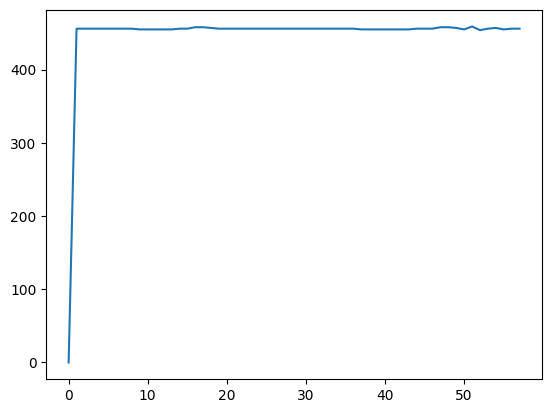

In [74]:
start_to_finish(100, 500, 4)

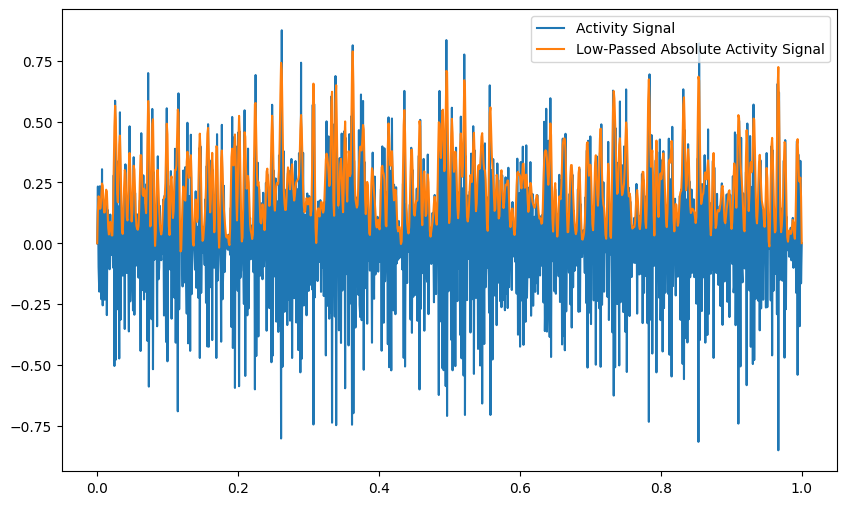

In [43]:
c_num = 40
# t, c = generate_dummy_data()
# l = filter(t, c, "high", CUTOFF_FREQ = 500)
t, c, l = time, activity, channel_MAD
plt.figure(figsize=(10, 6))
plt.plot(t, c[c_num], label='Activity Signal')
plt.plot(t, l[c_num], label='Low-Passed Absolute Activity Signal')
plt.legend()

In [ ]:
# first we will high-pass to get "activity" signal, then abs() + low-pass to obtain median absolute deviation
# a spike is then a time where absolute deviation > THRESHOLD * MAD
